# DenseNet Model 40x

this file will use folder "dataset_used" that generate from "BreakHisModel-1.ipynb"
and this will be used transfer learning / pre trained model RestNet

In [3]:
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.applications import ResNet50V2
from keras.layers import Input, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
from tensorboard.plugins.hparams import api as hp

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
# Clear any logs from previous runs
# rm -rf ./logs/

In [4]:
# Checking their lengths
# train 
len_train_benign = len(os.listdir("../data_magnify/40x/Cancer_train/benign/"))
len_train_malignant = len(os.listdir("../data_magnify/40x/Cancer_train/malignant/"))
# test 
len_test_benign = len(os.listdir("../data_magnify/40x/Cancer_test/benign/"))
len_test_malignant = len(os.listdir("../data_magnify/40x/Cancer_test/malignant/"))
# val 
len_validation_benign = len(os.listdir("../data_magnify/40x/Cancer_validation/benign/"))
len_validation_malignant = len(os.listdir("../data_magnify/40x/Cancer_validation/malignant/"))

print("Training Data:")
print(" ")
print("Benign   :", len_train_benign)
print("Malignant:", len_train_malignant)
print(" ")
print("Validation Data")
print(" ")
print("Benign size    :",len_validation_benign)
print("Malignant size :",len_validation_malignant)
print(" ")
print("Testing Data:")
print(" ")
print("Benign size    :",len_test_benign)
print("Malignant size :",len_test_malignant)

Training Data:
 
Benign   : 1108
Malignant: 1108
 
Validation Data
 
Benign size    : 34
Malignant size : 51
 
Testing Data:
 
Benign size    : 89
Malignant size : 211


# Image Data Generator
- Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- Generates batches of tensor image data with real-time data augmentation.
- Thus CNN sees new set of images with different variation at each epoch.
- One of the useful methods to prevent the model from Overfitting.

In [5]:
# Defining Image Data Generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    )

In [6]:
# Setting up the images for image data generator
train_generator = datagen.flow_from_directory(
  "../data_magnify/40x/Cancer_train/",
  target_size=(128, 128),
  class_mode="categorical",
  batch_size = 32,
  )

val_generator = datagen.flow_from_directory(
  "../data_magnify/40x/Cancer_validation/", 
  target_size=(128, 128), 
  class_mode="categorical",
  batch_size=32, 
  )

  # Loading the test data using Image Data Generator
test_generator = datagen.flow_from_directory(
  "../data_magnify/40x/Cancer_test/", 
  target_size=(128,128), 
  class_mode="categorical", 
  batch_size=1, 
  shuffle=False
  )

Found 2216 images belonging to 2 classes.
Found 85 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


# RestNet Layer config 
 
```fine_tune_at = 5 ```  
for RestNet 40x model  
```fine_tune_at = 50 ```  
for RestNet all magnify model

In [31]:
#Defining the base model -> Fine Tune
RestNet50v2_layer = ResNet50V2(
  include_top=False,
  input_shape=(128, 128, 3)
)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(RestNet50v2_layer.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in RestNet50v2_layer.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [8]:
RestNet50v2_layer.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']    

# LR optimizer
- tf.keras.optimizers.schedules.InverseTimeDecay

In [9]:
N_TRAIN = int(len_train_benign) * 2
BATCH_SIZE = 32
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [10]:
# Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate=0.001,
  decay_steps=STEPS_PER_EPOCH*5,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

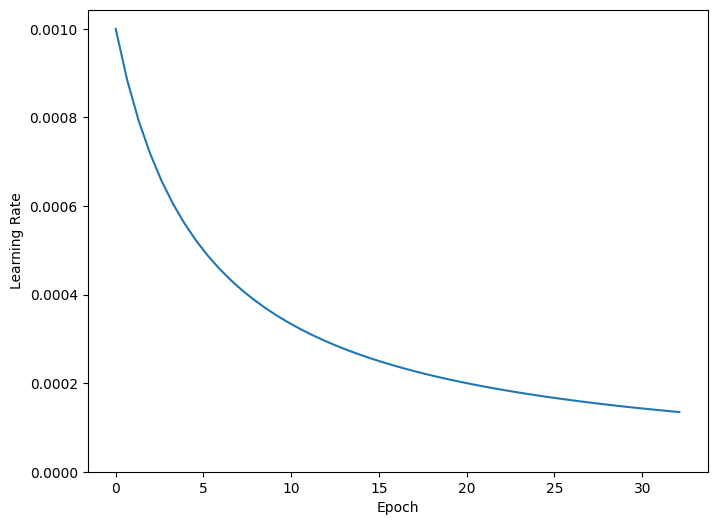

In [8]:
step = np.linspace(0,2216)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

# HyperParameter Tuning
- epoch[0, 0,2, 0,4]

In [13]:
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.0, 0.2, 0.4]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [15]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    # RestNet Layer
    RestNet50v2_layer,
    
    # Flattening the layers
    Flatten(),

    # Adding the dense layer
    Dropout(hparams[HP_DROPOUT]),
    Dense(256, activation='relu'),
    
    Dropout(hparams[HP_DROPOUT]),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax'),
  ])
  model.compile(
    loss='categorical_crossentropy', 
    optimizer = get_optimizer(), 
    metrics = ['accuracy']
  )

  model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=15,
    callbacks=[early_stop],
    verbose = 1
  ) # Run with 1 epoch to speed things up for demo purposes
  _, accuracy = model.evaluate(test_generator)
  return accuracy

In [16]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [17]:
start_time_HP = time.time()

session_num = 0
for dropout_rate in HP_DROPOUT.domain.values:
  hparams = {
    HP_DROPOUT: dropout_rate,
  }
  run_name = "run-%d" % session_num
  print('--- Starting trial: %s' % run_name)
  print({h.name: hparams[h] for h in hparams})
  run('logs/hparam_tuning/' + run_name, hparams)
  session_num += 1

--- Starting trial: run-0
{'dropout': 0.0}
Epoch 1/15
70/70 [==============================] - 86s 903ms/step - loss: 0.6090 - accuracy: 0.7590 - val_loss: 92.4981 - val_accuracy: 0.4118
Epoch 2/15
70/70 [==============================] - 56s 788ms/step - loss: 0.3457 - accuracy: 0.8542 - val_loss: 15.2799 - val_accuracy: 0.5529
Epoch 3/15
70/70 [==============================] - 57s 799ms/step - loss: 0.3062 - accuracy: 0.8962 - val_loss: 0.3407 - val_accuracy: 0.8706
Epoch 4/15
70/70 [==============================] - 63s 889ms/step - loss: 0.2086 - accuracy: 0.9273 - val_loss: 55.2038 - val_accuracy: 0.6118
Epoch 5/15
70/70 [==============================] - 57s 809ms/step - loss: 0.2851 - accuracy: 0.8912 - val_loss: 310.9136 - val_accuracy: 0.4588
Epoch 6/15
70/70 [==============================] - 58s 823ms/step - loss: 0.2118 - accuracy: 0.9138 - val_loss: 0.3317 - val_accuracy: 0.9059
Epoch 7/15
70/70 [==============================] - 58s 816ms/step - loss: 0.2497 - accuracy: 

In [18]:
end_time_HP = time.time()

In [19]:
Total_time_second= end_time_HP - start_time_HP
convert_minute = (Total_time_second) // 60
modulo_second = (Total_time_second) % 60
print("total time run HyperParameter Tune : {} Minutes, {} Seconds".format(convert_minute, modulo_second) )

total time run HyperParameter Tune : 45.0 Minutes, 6.292205333709717 Seconds


In [20]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 15412), started 2 days, 13:28:16 ago. (Use '!kill 15412' to kill it.)

# model CNN Pretrained model
- with DenseNet

In [32]:
cancer_model = Sequential([
  # RestNet Layer
  RestNet50v2_layer,
  
  # Flattening the layers
  Flatten(),
  Dropout(0.4),

  # Adding the dense layer
  Dense(256, activation='relu'),
  Dropout(0.4),
  
  Dense(128, activation='relu'),
  Dense(2, activation='softmax'),
])

# cancer_model.layers[0].trainable = False
cancer_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_4 (Dropout)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 2)                

In [33]:
# Compiling the model
cancer_model.compile(
  loss='categorical_crossentropy', 
  optimizer = get_optimizer(), 
  metrics = ['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [11]:
# Model is fitted using train and validation generator for 200 epochs
import time

start_time = time.time()

history = cancer_model.fit(
  train_generator, 
  validation_data=val_generator, 
  epochs=200 ,
  callbacks=[early_stop],
  verbose = 1
  )

Epoch 1/200
70/70 [==============================] - 82s 1s/step - loss: 0.7152 - accuracy: 0.6900 - val_loss: 27.4645 - val_accuracy: 0.6000
Epoch 2/200
70/70 [==============================] - 65s 918ms/step - loss: 0.4527 - accuracy: 0.7956 - val_loss: 7.8148 - val_accuracy: 0.6235
Epoch 3/200
70/70 [==============================] - 67s 952ms/step - loss: 0.3333 - accuracy: 0.8678 - val_loss: 1.0473 - val_accuracy: 0.8353
Epoch 4/200
70/70 [==============================] - 67s 953ms/step - loss: 0.2827 - accuracy: 0.8827 - val_loss: 0.5336 - val_accuracy: 0.7059
Epoch 5/200
70/70 [==============================] - 68s 966ms/step - loss: 0.2777 - accuracy: 0.8881 - val_loss: 0.6103 - val_accuracy: 0.8471
Epoch 6/200
70/70 [==============================] - 69s 971ms/step - loss: 0.1816 - accuracy: 0.9292 - val_loss: 0.2746 - val_accuracy: 0.8941
Epoch 7/200
70/70 [==============================] - 71s 1s/step - loss: 0.1635 - accuracy: 0.9296 - val_loss: 0.4979 - val_accuracy: 0.92

In [ ]:
end_time = time.time()
print("The time of execution of above program is :",(end_time-start_time) * 10**3, "ms")

The time of execution of above program is : 409386.27648353577 ms


In [ ]:
Total_time_second= end_time-start_time
convert_minute = (Total_time_second) // 60
modulo_second = (Total_time_second) % 60
print("total time run : {} Minutes, {} Seconds".format(convert_minute, modulo_second) )

total time run : 6.0 Minutes, 49.38627648353577 Seconds


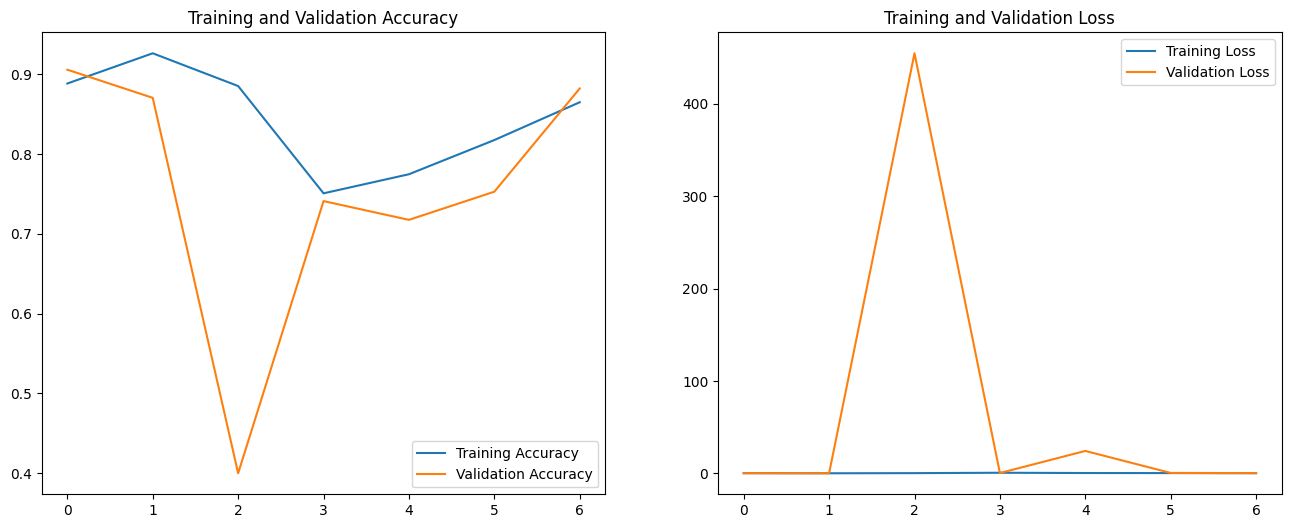

In [ ]:
# Plotting the model results

# Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

# No of epochs it trained
epochs_range = history.epoch

# Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
pred = cancer_model.evaluate(test_generator)

300/300 [==============================] - 17s 43ms/step - loss: 0.1289 - accuracy: 0.9600


In [ ]:
# os.mkdir("../src/output/restnet")

In [12]:
cancer_model.save(filepath="../src/output/restnet/restnet_40x_hp.h5")

# Load model and model evaluation

In [17]:
cancer_model.load_weights(filepath="../src/output/restnet/restnet_40x_hp.h5")

## test load model

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

pred = cancer_model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

print("==== Confusion Mtrix ====")
print(confusion_matrix(test_generator.classes, y_pred))

300/300 [==============================] - 12s 41ms/step
==== Confusion Mtrix ====
[[ 80   9]
 [  4 207]]


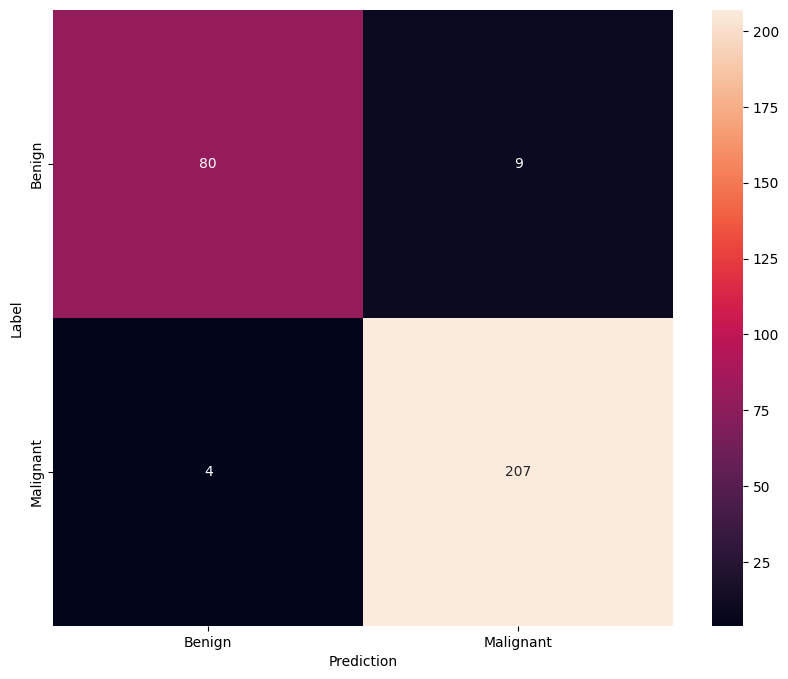

In [27]:
confusion_mtx = tf.math.confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [29]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92        89
           1       0.96      0.98      0.97       211

    accuracy                           0.96       300
   macro avg       0.96      0.94      0.95       300
weighted avg       0.96      0.96      0.96       300



# Load model and model evaluation with model all magnify

In [34]:
cancer_model.load_weights(filepath="../src/output/restnet/restnet50v2_model__HP_fineTune_FIX-v2.h5")

## test load model

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

pred = cancer_model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

print("==== Confusion Mtrix ====")
print(confusion_matrix(test_generator.classes, y_pred))

300/300 [==============================] - 13s 41ms/step
==== Confusion Mtrix ====
[[ 87   2]
 [ 15 196]]


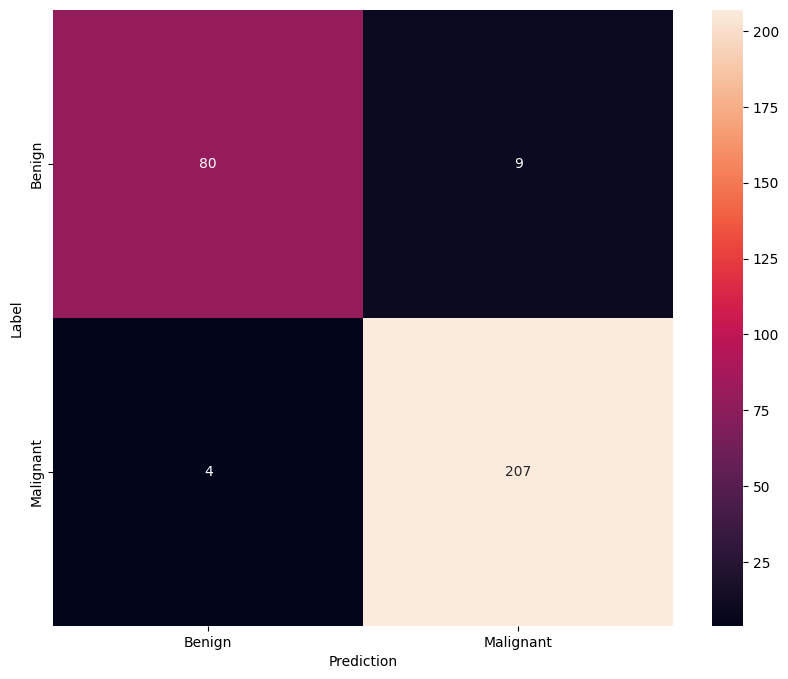

In [ ]:
confusion_mtx = tf.math.confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92        89
           1       0.96      0.98      0.97       211

    accuracy                           0.96       300
   macro avg       0.96      0.94      0.95       300
weighted avg       0.96      0.96      0.96       300

